<a href="https://colab.research.google.com/github/Sirisha-Dugyala/blog1/blob/main/trained_movinets_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Video Classification

This notebook provides basic example code to build, run, and fine-tune [MoViNets (Mobile Video Networks)](https://arxiv.org/pdf/2103.11511.pdf).

Pretrained models are provided by [TensorFlow Hub](https://tfhub.dev/google/collections/movinet/) and the [TensorFlow Model Garden](https://github.com/tensorflow/models/tree/master/official/projects/movinet), trained on [UCF101](https://www.crcv.ucf.edu/data/UCF101.php) for video action classification. All Models use TensorFlow 2 with Keras for inference and training.

The following steps will be performed:

1. [Installation](#scrollTo=dPx7Pp7fbgLY&uniqifier=1)
2. [Download a subset of the UCF101 dataset](#scrollTo=KbhwWLLM7FXo&uniqifier=1)
3. [Download a pre-trained MoViNet model](#scrollTo=aYYShfhMx9DW&uniqifier=1)
4. [Save and load model](#scrollTo=YDk6LAciJfnA&uniqifier=1)
5. [Evaluate the model](#scrollTo=KkLl2zF8G9W0&uniqifier=1)
6. [Inferencing using the trained model on GIF](#scrollTo=6s9Q_JBcVmN1&uniqifier=1)

**Note: Enabling GPU Acceleration**

To utilize GPU acceleration in Colab, follow these steps:

1. Click on the "Runtime" menu at the top.
2. Select "Change runtime type" from the dropdown menu.
3. In the dialog box, choose "GPU" as the hardware accelerator.
4. Click on the "Save" button.

Enabling GPU will allow you to take advantage of faster computation for deep learning tasks.










## Installation



In [1]:
%cd /content/

/content


In [3]:
%%capture
!pip install remotezip tqdm opencv-python==4.5.2.52 opencv-python-headless==4.5.2.52 tf-models-official
!pip install remotezip
!pip install tf-models-official
!pip install -q mediapy


In [2]:
!mkdir video_classification
%cd video_classification

/content/video_classification


Install Dependencies: Run the following code block to install the necessary dependencies, including remotezip, tqdm, opencv-python, tf-models-official, and other required packages.

Import Libraries: Make sure to import the essential libraries for video processing, data manipulation, visualization, and deep learning operations. Include the following modules in your code:

**NOTE!!**: Below code might give you an error but running it again would solve the issue

In [4]:
import tqdm
import random
import pathlib
import itertools
import collections
import os

import cv2
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

import mediapy as media


With these installation and import steps completed, you are now ready to leverage the power of MoViNet for accurate video classification.

Feel free to customize the installation and import instructions based on your specific needs.

## Download a subset of the UCF101 dataset

The [UCF101 dataset](https://www.tensorflow.org/datasets/catalog/ucf101) contains 101 categories of different actions in video, primarily used in action recognition. You will use a subset of these categories in this demo.

These helper functions collectively assist in various stages of video processing, model loading, classification, and result visualization. They enhance the functionality and usability of the code by encapsulating specific tasks and making the code more modular and organized.

In [5]:
#@title

def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]


def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped.

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

def download_from_zip(zip_url, to_dir, file_names):
  """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ucf_101_subset(zip_url, num_classes, splits, download_dir,classes_1):
  """ Download a subset of the UCF101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  # classes = list(files_for_class.keys())[:num_classes]
  classes = classes_1

  for cls in classes:
    random.shuffle(files_for_class[cls])

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [6]:
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [20]:
!pip install rarfile
!pip install requests

import remotezip as rz
import os
import pathlib
import random
import collections
import tqdm
import cv2
import numpy as np
import tensorflow as tf
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import tempfile  # Import tempfile for creating temporary files
import io  # Import io for working with in-memory streams
import rarfile  # Import rarfile for handling rar archives
import zipfile

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

def list_files_from_zip_url(zip_url):
    """
    List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
    """
    # Download the file in chunks and write to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix=".rar") as temp_file:  # Assume it's a rar file based on the URL
        with requests.get(zip_url, stream=True, verify=False) as response:
            response.raise_for_status()
            for chunk in response.iter_content(chunk_size=8192):
                temp_file.write(chunk)
        temp_file_path = temp_file.name

    # Use rarfile to extract files list from the downloaded rar file
    files = []
    with rarfile.RarFile(temp_file_path, 'r') as rar_ref:
        files = rar_ref.namelist()

    # Remove the temporary file
    os.remove(temp_file_path)
    return files

URL = "https://www.crcv.ucf.edu/data/UCF101/UCF101.rar"  # Updated URL to point to the rar file

files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c04.avi']

Begin with a few videos and a limited number of classes for training. After running the above code block, notice that the class name is included in the filename of each video.

Define the `get_class` function that retrieves the class name from a filename. Then, create a function called `get_files_per_class` which converts the list of all files (`files` above) into a dictionary listing the files for each class:

In [8]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

In [9]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

Once you have the list of files per class, you can choose how many classes you would like to use and how many videos you would like per class in order to create your dataset.

In [10]:
FILES_PER_CLASS = 100

In [14]:
import collections
import os

# Get the current working directory
current_directory = os.getcwd()

# Construct the full path to the file
file_path = os.path.join(current_directory, 'files_list.txt')

try:
    # Attempt to open the file
    with open(file_path, 'r') as f:
        files = [line.strip() for line in f]
except FileNotFoundError:
    # Handle the case where the file is not found
    print(f"Error: The file 'files_list.txt' was not found in {current_directory}.")
    print("Please make sure the file exists and is in the correct location.")
    # You can choose to exit the script here or proceed with alternative actions
    # For example:
    # import sys
    # sys.exit(1)  # Exit with an error code
    files = []  # Initialize files as an empty list to avoid further errors

# Continue with the rest of your code
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

Error: The file 'files_list.txt' was not found in /content/video_classification.
Please make sure the file exists and is in the correct location.


All the classes of UCF101 dataset

In [21]:
classes

[]

These are the selected classes from the above classes list

In [22]:
classes_1 = ['Archery',
 'BabyCrawling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'CliffDiving',
 'CuttingInKitchen',
 'Diving',
 'Fencing',
 'Hammering',
 'HammerThrow',
 'HighJump',
 'HulaHoop',
 'IceDancing',
 'JavelinThrow',
 'LongJump',
 'Mixing',
 'MoppingFloor',
 'PoleVault',
 'Punch',
 'SalsaSpin',
 'Shotput',
 'SumoWrestling',
 'TaiChi',
 'ThrowDiscus',
 'TrampolineJumping']

NUM_CLASSES = len(classes_1)

In [24]:
print('Num classes:', len(classes_1))
print('Num videos for class[0]:', len(files_for_class[classes_1[0]]))

Num classes: 25
Num videos for class[0]: 0


Create a new function called `select_subset_of_classes` that selects a subset of the classes present within the dataset and a particular number of files per class:

In [25]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [26]:
files_subset = select_subset_of_classes(files_for_class, classes_1, FILES_PER_CLASS)
list(files_subset.keys())

['Archery',
 'BabyCrawling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'CliffDiving',
 'CuttingInKitchen',
 'Diving',
 'Fencing',
 'Hammering',
 'HammerThrow',
 'HighJump',
 'HulaHoop',
 'IceDancing',
 'JavelinThrow',
 'LongJump',
 'Mixing',
 'MoppingFloor',
 'PoleVault',
 'Punch',
 'SalsaSpin',
 'Shotput',
 'SumoWrestling',
 'TaiChi',
 'ThrowDiscus',
 'TrampolineJumping']

Define helper functions that split the videos into training, validation, and test sets. The videos are downloaded from a URL with the zip file, and placed into their respective subdirectiories.

In [27]:
def download_from_zip(zip_url, to_dir, file_names):
  """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

The following function returns the remaining data that hasn't already been placed into a subset of data. It allows you to place that remaining data in the next specified subset of data.

In [28]:
def split_class_lists(files_for_class, count):
  """ Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Returns:
      Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

The following `download_ucf_101_subset` function allows you to download a subset of the UCF101 dataset and split it into the training, validation, and test sets. You can specify the number of classes that you would like to use. The `splits` argument allows you to pass in a dictionary in which the key values are the name of subset (example: "train") and the number of videos you would like to have per class.

In [29]:
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir,classes_1):
  """ Download a subset of the UCF101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  # classes = list(files_for_class.keys())[:num_classes]
  classes = classes_1

  for cls in classes:
    random.shuffle(files_for_class[cls])

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

The below URL contains a zip file with the UCF 101 dataset. Create a function that uses the `remotezip` library to examine the contents of the zip file in that URL:

In [32]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

In [33]:
!pip install zipfile

import os
import pathlib
import random
import requests
import zipfile
# ... other imports ...

def list_files_from_zip_url(zip_url):
    """Lists all files within a ZIP archive from a URL.

    Args:
      zip_url: The URL of the ZIP archive.

    Returns:
      A list of file paths within the ZIP archive.
    """

    try:
        response = requests.get(zip_url, stream=True)
        response.raise_for_status()  # Raise an exception for bad responses

        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            return zip_ref.namelist()

    except requests.exceptions.RequestException as e:
        print(f"Error downloading or opening ZIP file: {e}")
        return []

    except zipfile.BadZipFile as e:
        print(f"Invalid ZIP file: {e}")
        return []

ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


After downloading the data, you should now have a copy of a subset of the UCF101 dataset. Run the following code to print the total number of videos you have amongst all your subsets of data.

In [34]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 0


In [51]:
import sys
print(sys.executable)

/usr/bin/python3


## Create the training and test datasets

The labels generated here represent the encoding of the classes. For instance, 'ApplyEyeMakeup' is mapped to the integer Take a look at the labels of the training data to ensure that the dataset has been sufficiently shuffled.

In [66]:
def create_video_dataset(directory, labels='inferred', label_mode='int',
                         image_size=(IMG_HEIGHT, IMG_WIDTH), interpolation='nearest',
                         batch_size=BATCH_SIZE, shuffle=True):
    """
    Creates a TensorFlow dataset for video data.

    This function assumes videos are stored in subdirectories, where each
    subdirectory name represents a class label.

    Args:
        directory: The path to the directory containing video files.
        labels: Either "inferred" (labels are inferred from subdirectory names),
            or a list/tuple of integer labels for each example.
        label_mode: One of "int", "categorical", "binary", or None.
        image_size: The desired size of frames extracted from videos.
        interpolation: Interpolation method for resizing frames.
        batch_size: The batch size for the dataset.
        shuffle: Whether to shuffle the dataset.

    Returns:
        A TensorFlow dataset containing video data.
    """

    def video_to_frames(video_path):
        """Extracts frames from a video file and returns a tensor."""
        # Load the video
        vr = decord.VideoReader(video_path.numpy().decode('utf-8'))

        # Extract frames (adjust frame selection as needed)
        # Here we extract the first frame
        frame = vr[0].asnumpy()

        # Preprocess the frame (e.g., resize, normalize)
        frame = tf.image.resize(frame, image_size, method=interpolation)
        frame = frame / 255.0  # Normalize to [0, 1]

        return frame

    # Create a dataset of video file paths
    file_paths = []
    labels_list = []  # List to store labels
    for root, _, files in os.walk(directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
            # Extract label from directory name
            labels_list.append(os.path.basename(os.path.dirname(os.path.join(root, file))))

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels_list))  # Include labels

    # Map the video_to_frames function to extract frames and keep labels
    dataset = dataset.map(
        lambda x, y: (tf.py_function(video_to_frames, [x], tf.float32), y),  # Keep label 'y'
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch and shuffle
    dataset = dataset.batch(batch_size)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)

    return dataset

Take a look at the shape of the data.

In [70]:
import tensorflow as tf
import os

# Assuming you have defined IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, and create_video_dataset

# Define BUFFER_SIZE
BUFFER_SIZE = 1000  # Choose an appropriate buffer size for your dataset

# Create your dataset
train_dataset = create_video_dataset('UCF101_subset/train')

# Iterate over the dataset to get the frames and labels
# Initialize frames and labels outside the loop
frames = None
labels = None

for batch_frames, batch_labels in train_dataset.take(1):  # Take only 1 batch for demonstration
    frames = batch_frames  # Assign the values to the outer scope variables
    labels = batch_labels

# Now you can print the shapes outside the loop
if frames is not None and labels is not None:  # Check if frames and labels were assigned
    print(f"Shape: {frames.shape}")
    print(f"Label: {labels.shape}")
else:
    print("Dataset is empty or an error occurred.")

Dataset is empty or an error occurred.


In [75]:
!pip install decord ipywidgets

import tensorflow as tf
import os
import decord
import ipywidgets as widgets

# Define variables
IMG_HEIGHT = 128  # Adjust as needed
IMG_WIDTH = 128  # Adjust as needed
BATCH_SIZE = 32  # Adjust as needed

# Define BUFFER_SIZE
BUFFER_SIZE = 1000  # Choose an appropriate buffer size for your dataset

# Include create_video_dataset function here
def create_video_dataset(directory, labels='inferred', label_mode='int',
                         image_size=(IMG_HEIGHT, IMG_WIDTH), interpolation='nearest',
                         batch_size=BATCH_SIZE, shuffle=True):
    """
    Creates a TensorFlow dataset for video data.

    This function assumes videos are stored in subdirectories, where each
    subdirectory name represents a class label.

    Args:
        directory: The path to the directory containing video files.
        labels: Either "inferred" (labels are inferred from subdirectory names),
            or a list/tuple of integer labels for each example.
        label_mode: One of "int", "categorical", "binary", or None.
        image_size: The desired size of frames extracted from videos.
        interpolation: Interpolation method for resizing frames.
        batch_size: The batch size for the dataset.
        shuffle: Whether to shuffle the dataset.

    Returns:
        A TensorFlow dataset containing video data.
    """

    def video_to_frames(video_path):
        """Extracts frames from a video file and returns a tensor."""
        # Load the video
        vr = decord.VideoReader(video_path.numpy().decode('utf-8'))

        # Extract frames (adjust frame selection as needed)
        # Here we extract the first frame
        frame = vr[0].asnumpy()

        # Preprocess the frame (e.g., resize, normalize)
        frame = tf.image.resize(frame, image_size, method=interpolation)
        frame = frame / 255.0  # Normalize to [0, 1]

        return frame

    # Create a dataset of video file paths
    file_paths = []
    labels_list = []  # List to store labels
    for root, _, files in os.walk(directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
            # Extract label from directory name
            labels_list.append(os.path.basename(os.path.dirname(os.path.join(root, file))))

    # Check if any video files were found
    if not file_paths:
        print(f"Warning: No video files found in directory: {directory}")
        return tf.data.Dataset.from_tensor_slices(([], [])).batch(batch_size) # Return empty dataset

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels_list))  # Include labels

    # Map the video_to_frames function to extract frames and keep labels
    dataset = dataset.map(
        lambda x, y: (tf.py_function(video_to_frames, [x], tf.float32), y),  # Keep label 'y'
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch and shuffle

!pip install decord ipywidgets

import tensorflow as tf
import os
import decord
import ipywidgets as widgets

# Define variables
IMG_HEIGHT = 128  # Adjust as needed
IMG_WIDTH = 128  # Adjust as needed
BATCH_SIZE = 32  # Adjust as needed

# Define BUFFER_SIZE
BUFFER_SIZE = 1000  # Choose an appropriate buffer size for your dataset

# Include create_video_dataset function here
def create_video_dataset(directory, labels='inferred', label_mode='int',
                         image_size=(IMG_HEIGHT, IMG_WIDTH), interpolation='nearest',
                         batch_size=BATCH_SIZE, shuffle=True):
    """
    Creates a TensorFlow dataset for video data.

    This function assumes videos are stored in subdirectories, where each
    subdirectory name represents a class label.

    Args:
        directory: The path to the directory containing video files.
        labels: Either "inferred" (labels are inferred from subdirectory names),
            or a list/tuple of integer labels for each example.
        label_mode: One of "int", "categorical", "binary", or None.
        image_size: The desired size of frames extracted from videos.
        interpolation: Interpolation method for resizing frames.
        batch_size: The batch size for the dataset.
        shuffle: Whether to shuffle the dataset.

    Returns:
        A TensorFlow dataset containing video data.
    """

    def video_to_frames(video_path):
        """Extracts frames from a video file and returns a tensor."""
        # Load the video
        vr = decord.VideoReader(video_path.numpy().decode('utf-8'))

        # Extract frames (adjust frame selection as needed)
        # Here we extract the first frame
        frame = vr[0].asnumpy()

        # Preprocess the frame (e.g., resize, normalize)
        frame = tf.image.resize(frame, image_size, method=interpolation)
        frame = frame / 255.0  # Normalize to [0, 1]

        return frame

    # Create a dataset of video file paths
    file_paths = []
    labels_list = []  # List to store labels
    for root, _, files in os.walk(directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
            # Extract label from directory name
            labels_list.append(os.path.basename(os.path.dirname(os.path.join(root, file))))

    # Check if any video files were found
    if not file_paths:
        print(f"Warning: No video files found in directory: {directory}")
        return tf.data.Dataset.from_tensor_slices(([], [])).batch(batch_size) # Return empty dataset

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels_list))  # Include labels

    # Map the video_to_frames function to extract frames and keep labels
    dataset = dataset.map(
        lambda x, y: (tf.py_function(video_to_frames, [x], tf.float32), y),  # Keep label 'y'
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch and shuffle
    dataset = dataset.batch(batch_size)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)

    return dataset


## Download a pre-trained MoViNet model

In this section, we will:

1. We can create a MoViNet model using the open source code provided in [`official/projects/movinet`](https://github.com/tensorflow/models/tree/master/official/projects/movinet) from TensorFlow models.
2. Load the pretrained weights.
3. Freeze the convolutional base, or all other layers except the final classifier head, to speed up fine-tuning.

To build the model, we can start with the `a0` configuration because it is the fastest to train when benchmarked against other models. Check out the [available MoViNet models on TensorFlow Model Garden](https://github.com/tensorflow/models/blob/master/official/projects/movinet/configs/movinet.py) to find what might work for our use case.

In [76]:
model_id = 'a0'
resolution = 224

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

# Load pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


To build a classifier, create a function that takes the backbone and the number of classes in a dataset. The `build_classifier` function will take the backbone and the number of classes in a dataset to build the classifier. In this case, the new classifier will take a `num_classes` outputs (10 classes for this subset of UCF101).

In [77]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

In [78]:
batch_size, num_frames, resolution, backbone, NUM_CLASSES

(8,
 8,
 224,
 25)

In [79]:
model = build_classifier(batch_size, num_frames, resolution, backbone, NUM_CLASSES)

In [80]:
model.summary()

Model: "movinet_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 movinet (Movinet)           ({'stem': (None, None,    911583    
                             None, None, 8),                     
                              'block0_layer0': (None             
                             , None, None, None, 8),             
                              'block1_layer0': (None             
                             , None, None, None, 32)             
                             , 'block1_layer1': (Non             
                             e, None, None, None, 32             
                             ),                                  
                              'block1_layer2':

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the metrics argument to the view the accuracy of the model performance at every step.

In [82]:
!pip install tensorflow
import tensorflow as tf

# Assuming 'model' and 'loss_obj' are already defined

num_epochs = 2
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Use 'adam' string instead of optimizer object
model.compile(loss=loss_obj, optimizer='adam', metrics=['accuracy'])

Train the model. After two epochs, observe a low loss with high accuracy for both the training and test sets.

In [85]:
import tensorflow as tf

# Assuming you have your data in 'x_train', 'y_train', 'x_test', 'y_test'
# Before creating TensorFlow Datasets, ensure x_train, y_train, x_test, y_test are defined
# For demonstration purposes, I am creating sample data, replace with your actual data
import numpy as np
x_train = np.random.rand(100, 32, 32, 3)  # Example image data
y_train = np.random.randint(0, 10, size=100)  # Example labels
x_test = np.random.rand(20, 32, 32, 3)  # Example image data
y_test = np.random.randint(0, 10, size=20)  # Example labels


# Create TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

train_ds, test_ds # Now you can access them

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [88]:
import tensorflow as tf
import numpy as np

# ... (Your existing code for defining x_train, y_train, x_test, y_test) ...

# Reshape your data to add a temporal dimension of size 1 (single frame)
x_train = x_train.reshape((-1, 1, 32, 32, 3))  # Add a temporal dimension of size 1
x_test = x_test.reshape((-1, 1, 32, 32, 3))  # Add a temporal dimension of size 1

# Create TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Ensure model is compiled outside any @tf.function decorated functions.
# If you have data transformations, apply them before calling 'fit'. This avoids unexpected behavior due to in-place modifications.
num_epochs = 2
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss_obj, optimizer='adam', metrics=['accuracy']) # Ensure compile is called before fit

# ... (The rest of your code for model fitting) ...
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=num_epochs,
                    validation_freq=1,
                    verbose=1)

Epoch 1/2
4/4 [==============================] - 34s 5s/step - loss: 2.9526 - accuracy: 0.1600 - val_loss: 2.3380 - val_accuracy: 0.1500
Epoch 2/2
4/4 [==============================] - 0s 39ms/step - loss: 2.3189 - accuracy: 0.1300 - val_loss: 2.5410 - val_accuracy: 0.0500


## Save and load model

This block contains codes for saving and loading trained models

In [98]:
model.save('saved_model/my_model.keras') # Saves in the recommended .keras format

In [99]:
import shutil

# Specify the folder path to be downloaded
folder_path = '/content/saved_model/my_model'  # Replace with the actual path to your folder

# Create a zip file of the folder
shutil.make_archive('/content/my_model', 'zip', folder_path)


'/content/my_model.zip'

In [100]:
# Download the zip file
from google.colab import files

files.download('/content/my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [143]:
!unzip /content/my_model.zip -d /content/my_model

Archive:  /content/my_model.zip
warning [/content/my_model.zip]:  zipfile is empty


## Evaluate the model

The model achieved high accuracy on the training dataset. Next, use Keras `Model.evaluate` to evaluate it on the test set.

In [109]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])
  plt.savefig("loss.png")
  plt.show()

plot_history(results)

In [110]:
model.evaluate(test_ds, return_dict=True)

1/1 [==============================] - 0s 36ms/step - loss: 2.5410 - accuracy: 0.0500


{'loss': 2.5409634113311768, 'accuracy': 0.05000000074505806}

Confusion matrix

In [111]:
def get_actual_predicted_labels(model,dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [112]:
actual, predicted = get_actual_predicted_labels(model,test_ds)

1/1 [==============================] - 7s 7s/step


In [113]:
labels = classes_1

In [114]:
print(actual, tf.cast(predicted, tf.int16),labels, len(labels),sep = '\n')

tf.Tensor([0 9 0 6 7 6 5 2 1 5 0 1 4 7 4 2 6 4 8 5], shape=(20,), dtype=int64)
tf.Tensor([8 8 4 8 3 8 8 8 8 4 3 0 4 8 8 3 8 8 5 8], shape=(20,), dtype=int16)
['Archery', 'BabyCrawling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'CliffDiving', 'CuttingInKitchen', 'Diving', 'Fencing', 'Hammering', 'HammerThrow', 'HighJump', 'HulaHoop', 'IceDancing', 'JavelinThrow', 'LongJump', 'Mixing', 'MoppingFloor', 'PoleVault', 'Punch', 'SalsaSpin', 'Shotput', 'SumoWrestling', 'TaiChi', 'ThrowDiscus', 'TrampolineJumping']
25


In [122]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd

# Assuming 'actual' and 'predicted' are obtained from 'get_actual_predicted_labels'
# ... (your code to get actual and predicted)

# Get unique classes from both 'actual' and 'predicted' to ensure alignment
unique_classes = tf.unique(tf.concat([actual, predicted], axis=0))[0].numpy()
# Get the maximum class label value for both actual and predictions
num_classes = tf.reduce_max(tf.concat([actual, predicted], axis=0)).numpy() + 1

# Create confusion matrix using the determined 'num_classes'
con_mat = tf.math.confusion_matrix(
    labels=actual, predictions=predicted, num_classes=num_classes
).numpy()

# Update labels to match the unique classes
labels = [classes_1[i] for i in unique_classes if i < len(classes_1)]

con_mat_df = pd.DataFrame(con_mat, index=labels, columns=labels)

figure = plt.figure(figsize=(9, 9))
sns.heatmap(con_mat_df, annot=True, fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('Confusion_martix_test.png', bbox_inches='tight')
plt.show()

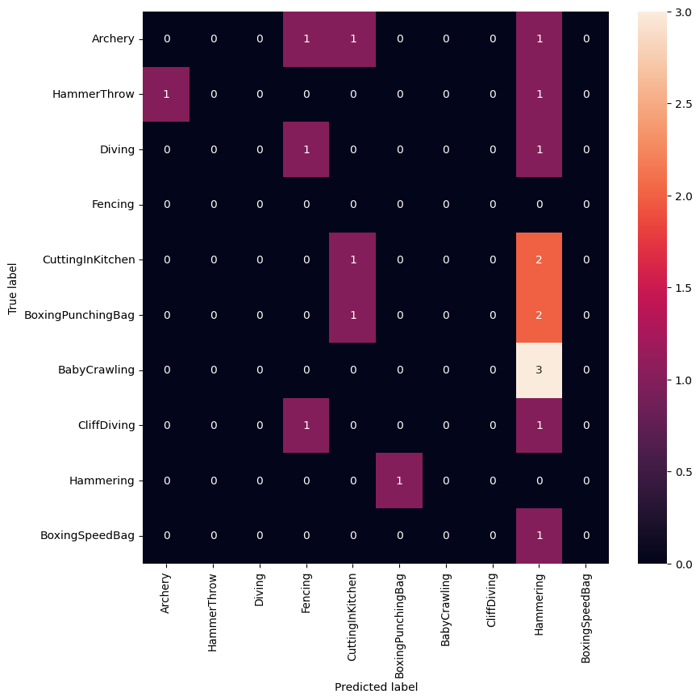

In [123]:
from PIL import Image
import IPython.display as display

# Open the image
image_path = '/content/video_classification/Confusion_martix_test.png'  # Replace with the actual path to your image
image = Image.open(image_path)

# Define the desired output size
output_size = (700, 700)  # Replace with your desired size

# Resize the image
image_resized = image.resize(output_size)

# Display the resized image
display.display(image_resized)


## Inferencing using the trained model on GIF

The same can be done on video input by following bellow method

In case of video input with shape ```(1, N*8, 244, 244, 3)``` we can split it into multiple samples with size ```( 1, 8, 244, 244, 3)``` and do the inference in a loop to obtain realtime detection results

Check what the classes are and number of classes

In [124]:
classes_1 = ['Archery',
 'BabyCrawling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'CliffDiving',
 'CuttingInKitchen',
 'Diving',
 'Fencing',
 'Hammering',
 'HammerThrow',
 'HighJump',
 'HulaHoop',
 'IceDancing',
 'JavelinThrow',
 'LongJump',
 'Mixing',
 'MoppingFloor',
 'PoleVault',
 'Punch',
 'SalsaSpin',
 'Shotput',
 'SumoWrestling',
 'TaiChi',
 'ThrowDiscus',
 'TrampolineJumping']

NUM_CLASSES = len(classes_1)

 The code takes a list of class labels `classes_1`, creates a list of unique classes, and generates one-hot encoded labels for each class in the original list. The resulting one-hot encoded labels are stored in the `labels_1` variable, which can be further used for tasks such as training machine learning models or performing categorical analysis.

In [125]:
import numpy as np

classes_one_hot = classes_1

# Create a list of unique classes
unique_classes = np.unique(classes_one_hot)

# Create one-hot encoded labels
labels = []
for c in classes_1:
    label = np.asarray([1 if c == cls else 0 for cls in unique_classes])
    labels.append(label)

labels_1 = np.asarray(labels)

# print(labels_1)

The provided code is designed for video inference in order to visualize the predicted output. It includes helper `load_gif`, `get_top_k` and `predict_top_k` functions that have been defined to facilitate smooth execution.

In [126]:
def load_gif(file_path, image_size=(224, 224)):
  """Loads a gif file into a TF tensor."""
  with tf.io.gfile.GFile(file_path, 'rb') as f:
    video = tf.io.decode_gif(f.read())
  video = tf.image.resize(video, image_size)
  video = tf.cast(video, tf.float32) / 255.
  return video

def get_top_k(probs, k=5, label_map=classes_1):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

def predict_top_k(model, video, k=5, label_map=classes_1):
  """Outputs the top k model labels and probabilities on the given video."""
  outputs = model.predict(video[tf.newaxis])[0]
  probs = tf.nn.softmax(outputs)
  return get_top_k(probs, k=k, label_map=label_map)

This folder is created for storing gif of the later use

In [127]:
!mkdir sample_gifs

The purpose of the code below is to traverse through all the files in the '/content/video_classification/UCF101_subset/test' directory. It randomly selects five videos from this directory for inference. Subsequently, it converts these selected videos into GIF format and saves them in the '/content/video_classification/sample_gifs' folder. The generated GIFs can be used for future inference tasks.

In [137]:
import os
import random
from moviepy.editor import VideoFileClip

# Specify the directory path
# directory = '/content/video_classification/UCF101_subset/test' # Original path - might be incorrect
directory = '/content/video_classification/UCF101_subset/train'  # Updated path - assuming data is directly under 'UCF101_subset'

save_dir = '/content/video_classification/sample_gifs'

# Ensure the directory exists before attempting to access it
if not os.path.exists(directory):
    print(f"Error: Directory '{directory}' not found.")
    # You might want to add code here to download the dataset or
    # create the directory if it's expected to be local.
    # For example:
import os
import random
from moviepy.editor import VideoFileClip

# Specify the directory path
# directory = '/content/video_classification/UCF101_subset/test' # Original path - might be incorrect
directory = '/content/video_classification/UCF101_subset/train'  # Updated path - assuming data is directly under 'UCF101_subset'

save_dir = '/content/video_classification/sample_gifs'

# Ensure the directory exists before attempting to access it
if not os.path.exists(directory):
    print(f"Error: Directory '{directory}' not found.")
    # You might want to add code here to download the dataset or
    # create the directory if it's expected to be local.
    # For example:
    # !wget -P /content/ <dataset_download_link>
    # !tar -xzf /content/<dataset_archive>.tar.gz
else:
    # Proceed with the rest of the code if the directory exists
    # ... (rest of your code) ...
    pass
from moviepy.editor import VideoFileClip

# Specify the directory path
# directory = '/content/video_classification/UCF101_subset/test' # Original path - might be incorrect
directory = '/content/video_classification/UCF101_subset/train'  # Updated path - assuming data is directly under 'UCF101_subset'

save_dir = '/content/video_classification/sample_gifs'

# Ensure the directory exists before attempting to access it
if not os.path.exists(directory):
    print(f"Error: Directory '{directory}' not found.")
    # You might want to add code here to download the dataset or
    # create the directory if it's expected to be local.
    # For example:
    # !wget -P /content/ <dataset_download_link>
    # !tar -xzf /content/<dataset_archive>.tar.gz
else:
    # Proceed with the rest of the code if the directory exists
    # ... (rest of your code) ...
    pass



The provided code iterates through all the files in the '/content/video_classification/sample_gifs' directory. It utilizes these files for video classification and presents the output in the form of a GIF and displays the top five predictions associated with the video classification task.

In [129]:
save_dir = '/content/video_classification/sample_gifs'
files = [file for file in os.listdir(save_dir) if file.endswith('.gif')]
for file_name in files:
  file_name = save_dir+'/'+file_name
  video = load_gif(file_name, image_size=(244, 244))
  media.show_video(video.numpy(), fps=23)
  outputs = predict_top_k(model, video)
  for label, prob in outputs:
    print(label, prob)

In [130]:
save_dir = '/content/video_classification/sample_gifs'
files = [file for file in os.listdir(save_dir) if file.endswith('.gif')]
for file_name in files:
  file_name = save_dir+'/'+file_name
  video = load_gif(file_name, image_size=(244, 244))
  media.show_video(video.numpy(), fps=23)
  outputs = predict_top_k(model, video)
  for label, prob in outputs:
    print(label, prob)